In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [136]:
# Track width and spacing
TRACK_WIDTH = 0.102
TRACK_SPACING = 0.2

# via defaults
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = False

# Stator hole
STATOR_HOLE_RADIUS = 5.5

# Coil net name
COIL_NET_NAME = "coils"

In [137]:
# Standard 25 mm version

# PCB Edge size
STATOR_RADIUS = 25
STATOR_HOLE_RADIUS = 10

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
TURNS = 9
COIL_CENTER_RADIUS = 16
COIL_VIA_RADIUS = 17

# Coil input vias
COIL_INPUT_VIA_RADIUS = 22

# Spiral
USE_SPIRAL = False

In [138]:
# Large 35 mm version

# PCB Edge size
#STATOR_RADIUS = 35

# where to puth the mounting pins
#SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
#SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
# for custom shape
#TURNS = 13
# for spiral
# TURNS = 17
#COIL_CENTER_RADIUS = 20.45
#COIL_VIA_RADIUS = 20.95

# Coil input vias
#COIL_INPUT_VIA_RADIUS = 27

# Arbitrary Coil Generation

In [139]:
# templates must be simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
template = [
    (-2.0, 0),
    (-2.0952, -0.7572),
    (0, -1.2866),
    (4.9013, -0.8147),
    (4.9013, 0),
    (4.9013, 0.8147),
    (0, 1.2866),
    (-2.0952, 0.7572),
]

(-2.4450250000000002, 5.251125, -1.41526, 1.41526)

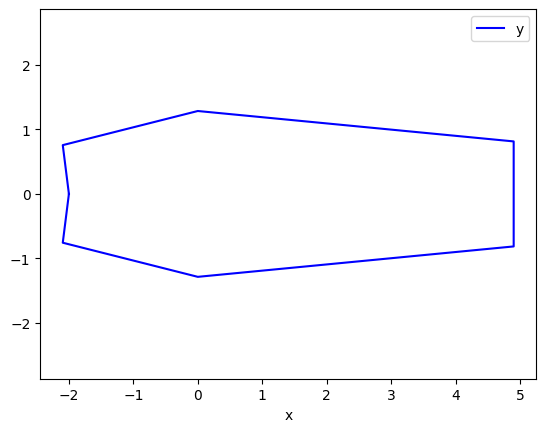

In [140]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [141]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = []
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

In [142]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = []
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [143]:
if not USE_SPIRAL:
    print("Not using spiral")
    template_f = []
    for i in range(len(template)):
        template_f.append(template[len(template) - i - len(template) // 2])
    template_f = flip_x(template_f)
    points_f = chaikin(
        optimize_points(
            flip_x(get_points(template_f, TURNS, TRACK_SPACING + TRACK_WIDTH))
        ),
        2,
    )
    points_b = chaikin(
        optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
    )
else:
    print("Using spiral")
    points_f = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))

Not using spiral
Optimised from 81 to 65 points
Optimised from 82 to 64 points


Track points 258 254


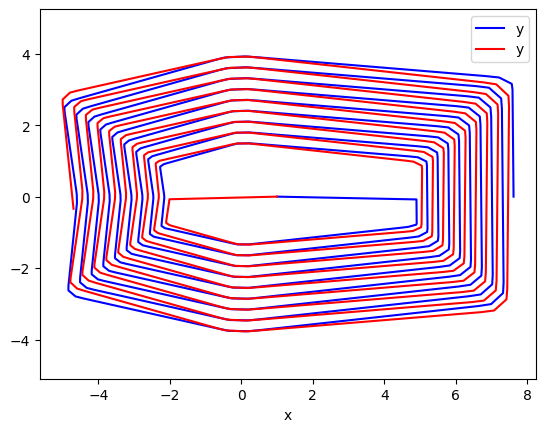

In [144]:
points_f = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_f
points_b = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_b

df = pd.DataFrame(points_f, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")
df = pd.DataFrame(points_b, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="red", ax=ax)

print("Track points", len(points_f), len(points_b))

# Generate PCB Layout

In [145]:
# calculate the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 249.22121246565396
Total length back 248.5736481812235


In [146]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []

# shift the coils around to make connections a bit easier
COIL_ROTATION = -360 / 12

coil_angles = []
for i in range(12):
    angle = i * 360 / 12 + COIL_ROTATION
    coil_angles.append(angle)

# the main coils
coil_labels = ["A", "B", "C"]
coils_f = []
coils_b = []
for i in range(12):
    angle = coil_angles[i]
    if (i // 3) % 2 == 0:
        coil_A_f = translate(rotate(points_f, angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(points_b, angle), COIL_CENTER_RADIUS, angle)
    else:
        # slightly nudge the coils so that they don't overlap when flipped
        coil_A_f = translate(rotate(flip_y(points_f), angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(flip_y(points_b), angle), COIL_CENTER_RADIUS, angle)
    # keep track of the coils
    coils_f.append(coil_A_f)
    coils_b.append(coil_A_b)

    tracks_f.append({"net": COIL_NET_NAME, "pts": coil_A_f})
    tracks_b.append({"net": COIL_NET_NAME, "pts": coil_A_b})





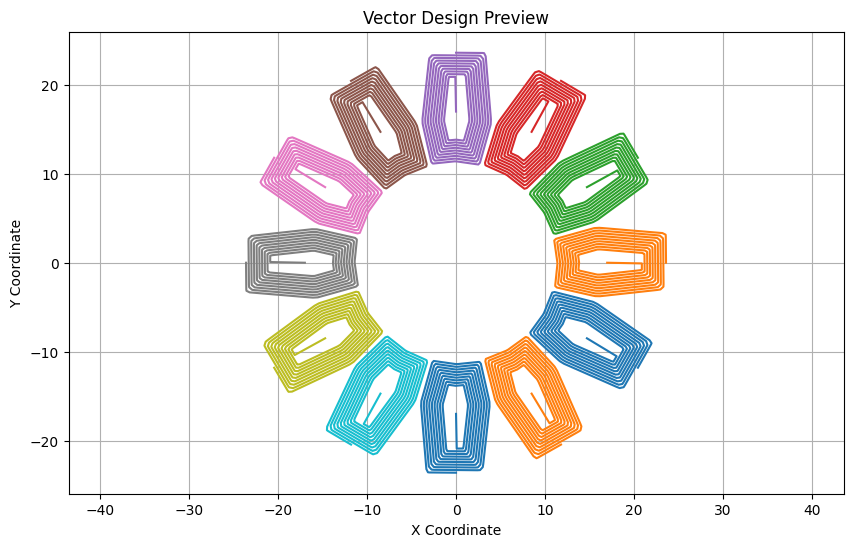

In [131]:
plt.figure(figsize=(10, 6))

for coil in tracks_f:
    #df = pd.DataFrame(coil["pts"], columns=["x", "y"])
    #ax = df.plot.line(x="x", y="y", color="red", ax=ax)
    #ax.axis("equal")

    # Extracting X and Y coordinates
    x_coords = [point[0] for point in coil['pts']]
    y_coords = [point[1] for point in coil['pts']]

    # Plotting
    plt.plot(x_coords, y_coords)  # 'o' is for circular markers
    plt.title('Vector Design Preview')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    # Show the plot
    plt.grid(True)
plt.show()

In [116]:
import ezdxf
doc = ezdxf.new(dxfversion='R2000')
msp = doc.modelspace() 

#for coil in tracks_f:
    #msp.add_lwpolyline(coil["pts"])
    #doc.saveas("coil_pcb.dxf")

In [147]:
for coil in tracks_f:
    points = coil["pts"]
    for pnt in points:
        pnt[0] = round(pnt[0] * 1e-3, 6)
        pnt[1] = round(pnt[1] * 1e-3, 6) 
    print(points)
    for i in range(len(points) - 1):
        start_point = points[i]
        end_point = points[i + 1]
        msp.add_line(start_point, end_point)
doc.saveas("test_pcb_mm.dxf")

[[0.014722, -0.0085], [0.018063, -0.010519], [0.017735, -0.011098], [0.017705, -0.011127], [0.017483, -0.01107], [0.017267, -0.010977], [0.013601, -0.009367], [0.013382, -0.009269], [0.013102, -0.00911], [0.013011, -0.009031], [0.011645, -0.007774], [0.011566, -0.007698], [0.011513, -0.007597], [0.011533, -0.00756], [0.011943, -0.006993], [0.011968, -0.006958], [0.012005, -0.006889], [0.012022, -0.006848], [0.012288, -0.006177], [0.012309, -0.006139], [0.012426, -0.006127], [0.012535, -0.006153], [0.014379, -0.006621], [0.014498, -0.006656], [0.014794, -0.006817], [0.015004, -0.00696], [0.018488, -0.009373], [0.018689, -0.009519], [0.018835, -0.009739], [0.018795, -0.009836], [0.017927, -0.011373], [0.017865, -0.011457], [0.017599, -0.011447], [0.017368, -0.011351], [0.013462, -0.009636], [0.013228, -0.009531], [0.012925, -0.009356], [0.012822, -0.009267], [0.011265, -0.007834], [0.011175, -0.007748], [0.011118, -0.007629], [0.011143, -0.007582], [0.011663, -0.006865], [0.011695, -0.00